In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sym
import numpy as np
import scipy as sp

sns.set()

In [2]:
def sim(runway_dist=10_000, angle=5, init_vel=200/3.6, acc_dev=2):
    cosx = np.cos(angle * (np.pi / 180))
    sinx = np.sin(angle * (np.pi / 180))

    def state(d):
        # Return the real state as a function d
        return np.array([d * cosx, 0, d * sinx])  # [x,y,z]
    
    def ra(d): # The 'averaged' signal from two radars
        return np.sqrt((1000 - d*np.cos(5*(np.pi/180)))**2 + (500)**2 + (d*np.sin(5*(np.pi/180)))**2)

    def rb(d): # The 'averaged' signal from two radars
        return np.sqrt((-500 - d*np.cos(5*(np.pi/180)))**2 + (500)**2 + (d*np.sin(5*(np.pi/180)))**2)
        
    def ry(d):
        return d*np.sin(5*(np.pi/180))

    # d is the radial distance (of the plane) away from the origin
    d = runway_dist / cosx  # Starting d
    v = init_vel
    
    while d > 0:
        yield (
            d,
            state(d), 
            v,  # Multiply v by 3.6 to get km/h
            ra(d) + np.random.randn() * np.sqrt(20**2 / 2),
            rb(d) + np.random.randn() * np.sqrt(20**2 / 2),
            ry(d) + np.random.randn() * 5,
        )
        
        v += np.random.randn() * acc_dev
        d -= v  # d -= vel*dt, where dt = 1

In [3]:
ys = list(sim())

In [4]:
ds = [y[0] for y in ys]
ss = [y[1] for y in ys]
vs = [y[2] for y in ys]
ras = [y[3] for y in ys]
rbs = [y[4] for y in ys]
rys = [y[5] for y in ys]

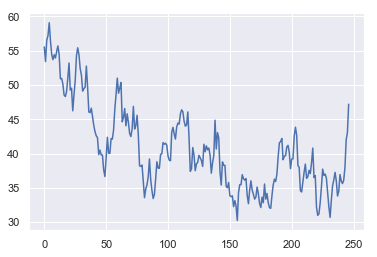

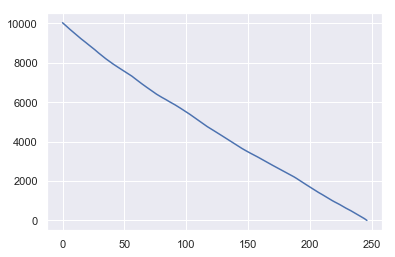

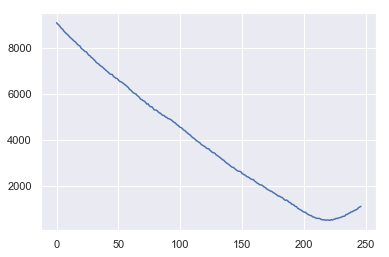

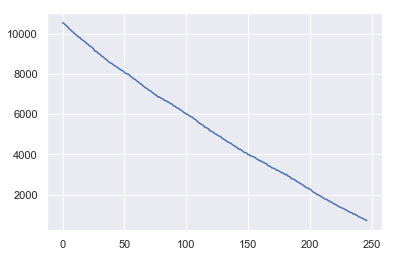

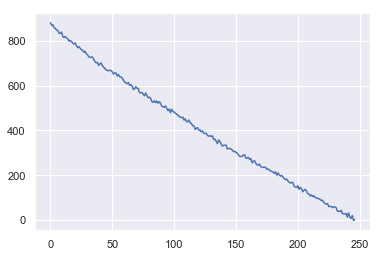

In [5]:
plt.plot(vs)
plt.show()
plt.plot(ds)
plt.show()
plt.plot(ras)
plt.show()
plt.plot(rbs)
plt.show()
plt.plot(rys)
plt.show()

# Defining the problem

We can define the state to be 
$$
    \begin{bmatrix}
        d \\ v
    \end{bmatrix}
$$
Where $d$ is the radial distance away from the origin, and $v$ is the velocity in the same direction.

We have 5 measurements that we take but due to the symmetry about the y-axis we can reduce this down to 3 measurements in the Kalman Filter

Let's define the average of the two measurements at $x=1000$ to be $r_a$, and the the average of the two measurements at $x=-500$ to be $r_b$, we do this because it allows us to effectively half the variance for each of these measurements (good!). The height measurement we can define as $r_h$. 

More concretely
$$
    r_a[n] = \frac{1}{2} \Big( r_{(1000,500)}[n] + r_{(1000,-500)}[n] \Big)
$$
and
$$
    r_b[n] = \frac{1}{2} \Big( r_{(-500,500)}[n] + r_{(-500,-500)}[n] \Big)
$$
Where $n$ is the $n^{th}$ timestep since the start of measurements (ie when the plane was 10km away along the ground)



<br>

# Update and prediction portion

## Update matrix
We know that from the problem the update matrix will be:

$$
    A = \begin{bmatrix}
        1 & \Delta t \\
        0 & 1
    \end{bmatrix}
$$

And the gain update matrix

$$
    B = \begin{bmatrix}
        0 \\
        1
    \end{bmatrix}
$$

And with the update covariance: 

$$
    Q_u = \begin{bmatrix}
        0 & 0 \\
        0 & 4
    \end{bmatrix}
$$

This basically says that there is no variance on the position (directly) and a variance on velocity of $2^2 = 4 \frac{m}{s^2}$ 

<br>

# Sensitivity matrix
## Finding the H matrix
We can also define the $H$ matrix using simple trigonometry. 

First we find what the radial distance from each sensor (also remember we use the 'fake' $r_a$ and $r_b$ here):

$$
    \begin{align*}
        r_a(d) &= \sqrt{ (1000 - d\ cos(5°))^2 + (500)^2 + (d\ sin(5°))^2 } \\
        r_b(d) &= \sqrt{ (-500 - d\ cos(5°))^2 + (500)^2 + (d\ sin(5°))^2 } \\
        r_h(d) &= d\ sin(5°) \\
    \end{align*}
$$

So we get the following $H$:

$$
    H = \begin{bmatrix}
        \sqrt{ (1000 - d\ cos(5°))^2 + (500)^2 + (d\ sin(5°))^2 }  & 0 \\
        \sqrt{ (-500 - d\ cos(5°))^2 + (500)^2 + (d\ sin(5°))^2 }  & 0 \\
        d\ sin(5°)  & 0 \\
    \end{bmatrix}
$$


Where we know from the question that the measurement covariance will be:

$$
    Q_w = \begin{bmatrix}
        \frac{1}{2}(20^2) & 0 & 0 \\
        0 & \frac{1}{2}(20^2) & 0 \\        
        0 & 0 & 5^2 \\
    \end{bmatrix} = \begin{bmatrix}
        200 & 0 & 0 \\
        0 & 200 & 0 \\        
        0 & 0 & 25 \\
    \end{bmatrix}
$$

The reason for the $\frac{1}{2}$ (as mentioned above) is due to having two symmetric measurements which are then averaged, effectively creating a new single measurement with half the variance of the two original measurements.


# Setup

Similarily to the lecture slides we will have:

The state vector:
$$s(n) = \begin{bmatrix} d_n \\ v_n \end{bmatrix}$$


The update equation can be written as:
$$
    \begin{bmatrix}
        d_n \\ v_n
    \end{bmatrix} = \begin{bmatrix}
        1 & -1 \\
        0 & 1
    \end{bmatrix} \begin{bmatrix}
        d_{n-1} \\ v_{n-1}
    \end{bmatrix} + \begin{bmatrix}
        0 \\ u_n
    \end{bmatrix}
$$

The initial state:
$$
    s(0,0) = \begin{bmatrix}
        d_0 \\ v_0
    \end{bmatrix} = \begin{bmatrix}
        10000\frac{1}{cos(5°)} \\ 200000
    \end{bmatrix}
$$

The initial uncertainty is zero (assumption from the question):
$$M(0,0) = 0$$

In [6]:
# Setup stuff
dt = 1  # Δt = 1 second

A = np.array([[1, -dt], [0, 1]])
B = np.array([[1],[0]])

Qu = np.array([[0, 0], [0, 4]])
Qw = np.array([[200, 0, 0], [0, 200, 0], [0, 0, 25]])

def H(d):
    cos5 = np.cos(5 * (np.pi/180))
    sin5 = np.sin(5 * (np.pi/180))
    xp = d * cos5
    zp = d * sin5  # Note this is the z component from the original question not y
    rp = np.array([xp, 0, zp]).T
    R1p = np.array([xp - 1000, 500, zp])
    R2p = np.array([xp + 500, 500, zp])
    return np.array([
        [(R1p @ rp) / (np.linalg.norm(R1p) * np.linalg.norm(rp)), 0],
        [(R2p @ rp) / (np.linalg.norm(R2p) * np.linalg.norm(rp)), 0],
        [sin5, 0],
    ]), np.linalg.norm(R1p), np.linalg.norm(R2p), zp

In [7]:
# Initialize all the things to be used

smm = np.array([10_000 / (np.cos(5 * (np.pi/180))), 200/3.6])  # velocity in m/s not km/h
Mmm = np.zeros((2,2)) 

Nt = len(ds)
zs = np.zeros((Nt, 3)) 
zs[:, 0] = ras
zs[:, 1] = rbs
zs[:, 2] = rys
Ks = []
d_preds = []
v_preds = []
dd_covs = []
vv_covs = []
dv_covs = []

# main KF loop
for k, z in enumerate(zs):
    skm = A @ smm  # prediction
    d = skm[0]
    Mkm = A @ Mmm @ A.T + Qu  # covariance of prediction
    h, R1, R2, zp = H(d)
    K = Mkm @ h.T @ np.linalg.inv(h @ Mkm @ h.T + Qw)  # Kalman gain matrix
    skk = skm + K @ (z - np.array([R1, R2, zp]))   # correction    
    Mmm = (np.eye(2) - K @ h) @ Mkm   # update the covariance
    smm = skk   # ready for new round
    Ks.append(K)
    d_preds.append(skk[0])
    dd_covs.append(Mmm[0,0])
    v_preds.append(skk[1])
    vv_covs.append(Mmm[1,1])
    dv_covs.append(Mmm[0,1])  # Should be equal to Mmm[1,0] since it is a covariance

Ks = np.array(Ks)
d_preds = np.array(d_preds)
v_preds = np.array(v_preds)
dd_covs = np.array(dd_covs)
vv_covs = np.array(vv_covs)
dv_covs = np.array(dv_covs)

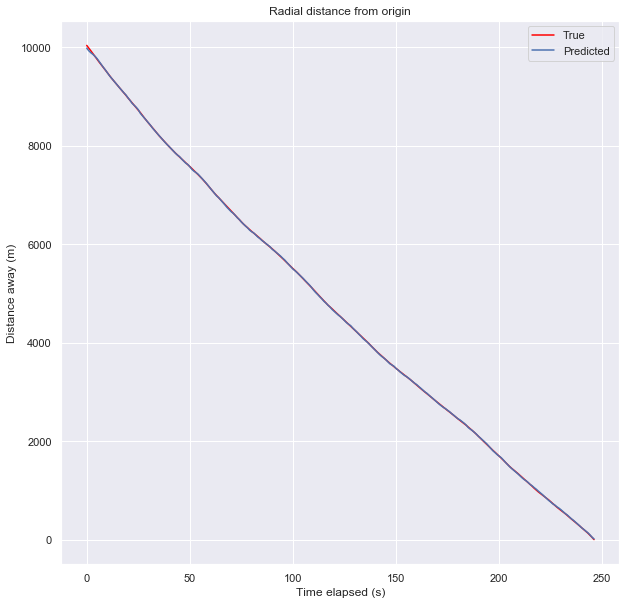

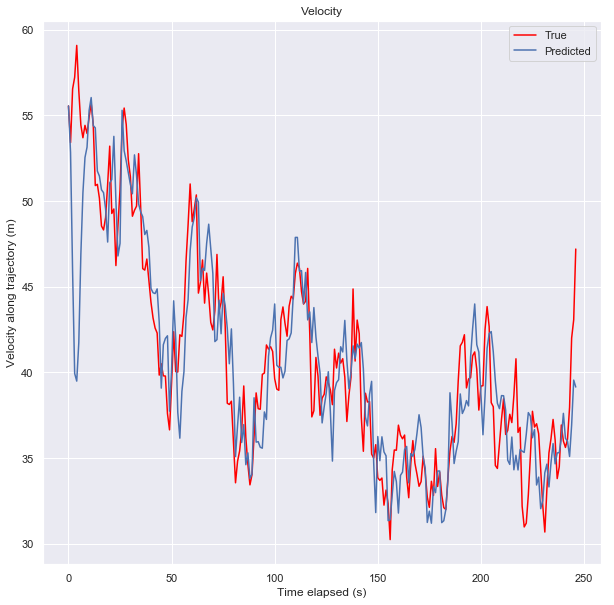

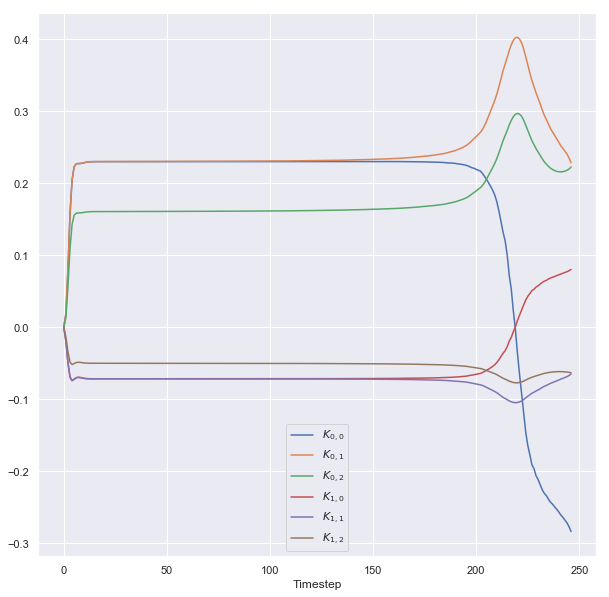

In [8]:
plt.rcParams["figure.figsize"] = (10,10)

plt.plot(ds, label='True', color='red')
plt.plot(d_preds, label='Predicted')
plt.title('Radial distance from origin')
plt.ylabel('Distance away (m)')
plt.xlabel('Time elapsed (s)')
plt.legend()
plt.show()

plt.plot(vs, label='True', color='red')
plt.plot(v_preds, label='Predicted')
plt.title('Velocity')
plt.ylabel('Velocity along trajectory (m)')
plt.xlabel('Time elapsed (s)')
plt.legend()
plt.show()

for i in range(Ks.shape[1]):
    for j in range(Ks.shape[2]):
        plt.plot(Ks[:,i,j], label='$K_{'+str(i)+','+str(j)+'}$')
plt.xlabel('Timestep')
plt.legend(loc='lower center')
plt.show()

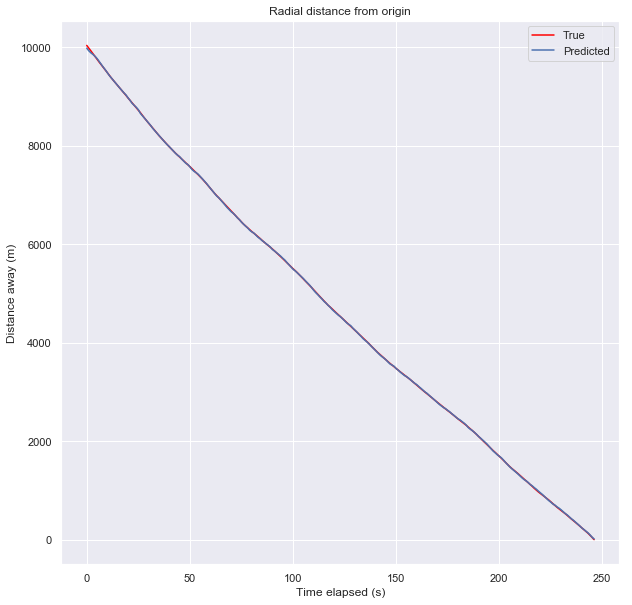

Note the tiny covariance!


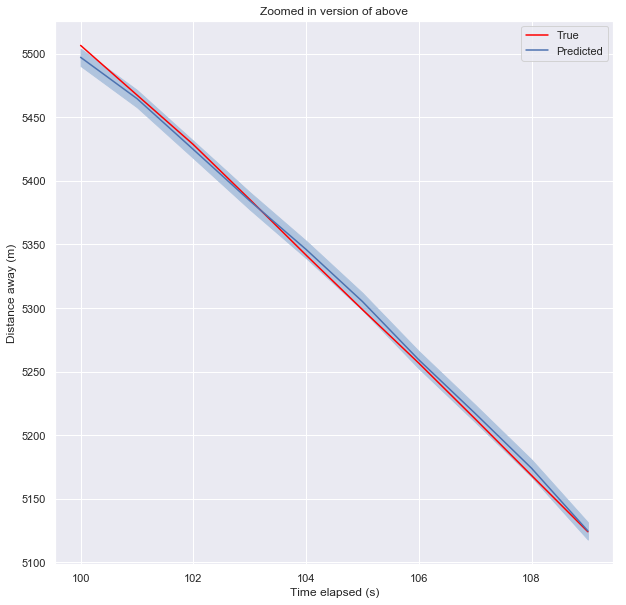

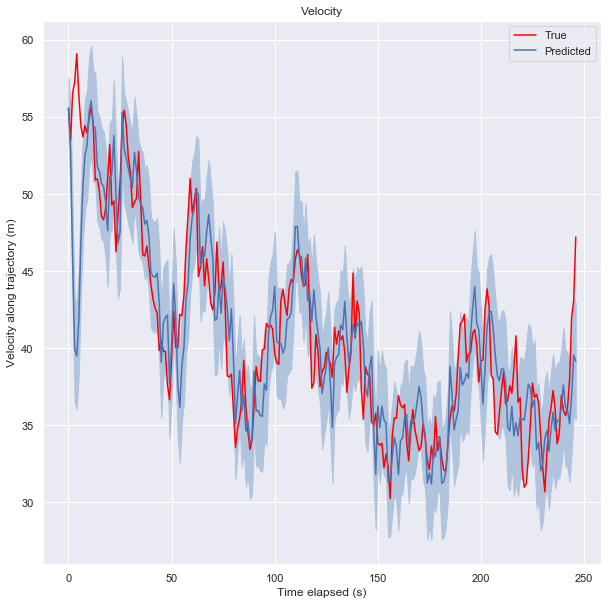

In [9]:
x = np.arange(Nt)

# Note: we have to plot in an overly complicated  because seaborn doesn't want to let you set your own damn variance in sns.lineplot...

# Distance with variance
dd_stds = np.sqrt(dd_covs)
y1 = d_preds - dd_stds
y2 = d_preds + dd_stds
plt.plot(x, ds, label='True', color='red')
plt.fill_between(x, y1=y1, y2=y2, color='lightsteelblue')
plt.plot(x, d_preds, label='Predicted')
plt.title('Radial distance from origin')
plt.ylabel('Distance away (m)')
plt.xlabel('Time elapsed (s)')
plt.legend()
plt.show()
print('Note the tiny covariance!')

# Zoomed in version
plt.plot(x[100:110], ds[100:110], label='True', color='red')
plt.fill_between(x[100:110], y1=y1[100:110], y2=y2[100:110], color='lightsteelblue')
plt.plot(x[100:110], d_preds[100:110], label='Predicted')
plt.title('Zoomed in version of above')
plt.ylabel('Distance away (m)')
plt.xlabel('Time elapsed (s)')
plt.legend()
plt.show()


# Velocity with variance
vv_stds = np.sqrt(vv_covs)
err_kws = {
    'y1': v_preds - vv_stds,
    'y2': v_preds + vv_stds,    
}
plt.plot(x, vs, label='True', color='red')
plt.fill_between(x, y1=v_preds-vv_stds, y2=v_preds+vv_stds, color='lightsteelblue')
plt.plot(x, v_preds, label='Predicted')
plt.title('Velocity')
plt.ylabel('Velocity along trajectory (m)')
plt.xlabel('Time elapsed (s)')
plt.legend()
plt.show()

<br><hr>

# Part 2

Now consider the more realistic problem that the plane can have a sideways acceleration say due to wind. Consider modelling this with a random walk in lateral distance from the ideal flight path. Discuss what changes you would make to the EKF to accommodate this additional movement. Would the MLS be able to detect this lateral displacement error to correct the flight path? Simulation is not required for this part just a well reasoned discussion.

## Answer

#### Changes
The first thing that would need to be done is expand the state space to include the lateral movement and velocity, or optionally simply use $x, y, \text{ and } z$ coordinates as well as their velocities as the coordinate system. In addition we would also need to measure or estimate the variance of the noise from wind will be.

$$s = \begin{bmatrix} d \\ l \\ v_d \\ v_l \end{bmatrix}$$
Where $l$ is the lateral position (value of the y coordinate) and $v_d$ is the velocity in that direction.


The second major change would be to use all 5 radars again. In part A we were able to simplify the problem down by reducing 5 signals to 3 and halving the variance of the radial sensors. To estimate $y$ we would need to once again use all the sensors to be able to sense differences in distance from sensors on each side of the y axis.


#### Problems
Due to our simplification of the problem we were able to gain more accurate estimations is the states that we estimated (distance away from origin and velocity), unfortunately measuring additional things will reduce the amount of information we get from each signal (therefore increasing the minimum variance of our estimator).

To do an analyis on whether we will be able to get a meaninful value for the lateral movement is a completely different question and would depend on all of the noises in the system and whether the linearization is accurate enough (for the EKF). So while it is possible to measure the lateral movements, it is not clear from simple inspection whether it will give useful results (ie estimates that will actually be useful for controlling the plane).


#### Problem with wind as a random acceleration
When modelling the flight of the plane it made sense to model the deviation of the velocity to do wind or other factors along the flight path. The plane will always end up in the same place just in a different period of time each time you simulate it. This does not hold true for lateral wind forces. The plane must always still land on the runway so there must be some force that brings it back closer to it's flight path.

In the real world it will be very important to add this 'correction' into the derivation of the EKF, one way this could be done is by adding the 'correction' into the 
$$\dot x = Ax + Bu$$ 
portion of the derivations by figuring out exactly how the 'controller' will work. This essentially makes the tranfer function closed loop instead of open loop.

<br>
So hypothetically you could have the MLS lateral displacement error to correct the flight path, assuming you have accurate enough sensors, but it would be useful to first decide on the exact control being used to be able to take advantage of that in the derivations.
